# Part 4: Quantization

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os

#os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

2024-04-06 16:44:33.368327: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Fetch the jet tagging dataset from Open ML

In [2]:
X_train_val = np.load('X_train_val.npy')
X_test = np.load('X_test.npy')
y_train_val = np.load('y_train_val.npy')
y_test = np.load('y_test.npy')
classes = np.load('classes.npy', allow_pickle=True)

## Construct a model
This time we're going to use QKeras layers.
QKeras is "Quantized Keras" for deep heterogeneous quantization of ML models.

https://github.com/google/qkeras

It is maintained by Google and we recently added support for QKeras model to hls4ml.

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks
from tensorflow.keras.layers import Activation
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu

We're using `QDense` layer instead of `Dense`, and `QActivation` instead of `Activation`. We're also specifying `kernel_quantizer = quantized_bits(6,0,0)`. This will use 6-bits (of which 0 are integer) for the weights. We also use the same quantization for the biases, and `quantized_relu(6)` for 6-bit ReLU activations.

In [4]:
model = Sequential()
model.add(
    QDense(
        64,
        input_shape=(16,),
        name='fc1',
        kernel_quantizer=quantized_bits(6, 0, alpha=1),
        bias_quantizer=quantized_bits(6, 0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
    )
)
model.add(QActivation(activation=quantized_relu(6), name='relu1'))
model.add(
    QDense(
        32,
        name='fc2',
        kernel_quantizer=quantized_bits(6, 0, alpha=1),
        bias_quantizer=quantized_bits(6, 0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
    )
)
model.add(QActivation(activation=quantized_relu(6), name='relu2'))
model.add(
    QDense(
        32,
        name='fc3',
        kernel_quantizer=quantized_bits(6, 0, alpha=1),
        bias_quantizer=quantized_bits(6, 0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
    )
)
model.add(QActivation(activation=quantized_relu(6), name='relu3'))
model.add(
    QDense(
        5,
        name='output',
        kernel_quantizer=quantized_bits(6, 0, alpha=1),
        bias_quantizer=quantized_bits(6, 0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
    )
)
model.add(Activation(activation='softmax', name='softmax'))

2024-04-06 16:48:07.949364: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## Train sparse
Let's train with model sparsity again, since QKeras layers are prunable.

In [5]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(0.75, begin_step=2000, frequency=100)}
model = prune.prune_low_magnitude(model, **pruning_params)

## Train the model
We'll use the same settings as the model for part 1: Adam optimizer with categorical crossentropy loss.
The callbacks will decay the learning rate and save the model into a directory 'model_2'
The model isn't very complex, so this should just take a few minutes even on the CPU.
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model rather than training again.

In [6]:
train = True
if train:
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir='model_3',
    )
    callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
    model.fit(
        X_train_val,
        y_train_val,
        batch_size=1024,
        epochs=30,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )
    # Save the model again but with the pruning 'stripped' to use the regular layer types
    model = strip_pruning(model)
    model.save('model_3/KERAS_check_best_model.h5')
else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects

    co = {}
    _add_supported_quantized_objects(co)
    model = load_model('model_3/KERAS_check_best_model.h5', custom_objects=co)

Epoch 1/30
476/487 [============================>.] - ETA: 0s - loss: 0.9761 - accuracy: 0.6809
***callbacks***
saving losses to model_3/losses.log

Epoch 1: val_loss improved from inf to 0.81107, saving model to model_3/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 0.81107, saving model to model_3/KERAS_check_best_model_weights.h5

Epoch 1: saving model to model_3/KERAS_check_model_last.h5

Epoch 1: saving model to model_3/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 6s 7ms/step - loss: 0.9725 - accuracy: 0.6821 - val_loss: 0.8111 - val_accuracy: 0.7372 - lr: 0.0010
Epoch 2/30
480/487 [============================>.] - ETA: 0s - loss: 0.7820 - accuracy: 0.7454
***callbacks***
saving losses to model_3/losses.log

Epoch 2: val_loss improved from 0.81107 to 0.77080, saving model to model_3/KERAS_check_best_model.h5

Epoch 2: val_loss improved from 0.81107 to 0.77080, saving model to model_3/KERAS_check_best_model_w

## Check performance
How does this model which was trained using 6-bits, and 75% sparsity model compare against the original model? Let's report the accuracy and make a ROC curve. The quantized, pruned model is shown with solid lines, the unpruned model from part 1 is shown with dashed lines.


We should also check that hls4ml can respect the choice to use 6-bits throughout the model, and match the accuracy. We'll generate a configuration from this Quantized model, and plot its performance as the dotted line.
The generated configuration is printed out. You'll notice that it uses 7 bits for the type, but we specified 6!? That's just because QKeras doesn't count the sign-bit when we specify the number of bits, so the type that actually gets used needs 1 more.

We also use the `OutputRoundingSaturationMode` optimizer pass of `hls4ml` to set the Activation layers to round, rather than truncate, the cast. This is important for getting good model accuracy when using small bit precision activations. And we'll set a different data type for the tables used in the Softmax, just for a bit of extra performance.


**Make sure you've trained the model from part 1**

In [8]:
import hls4ml
import plotting

config = hls4ml.utils.config_from_keras_model(model, granularity='name')
config['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<18,8>'
config['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<18,4>'
print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='model_3/hls4ml_prj', part='xc7a100tfgg676-2L'
)
hls_model.compile()

y_qkeras = model.predict(np.ascontiguousarray(X_test))
y_hls = hls_model.predict(np.ascontiguousarray(X_test))
np.save('model_3/y_qkeras.npy', y_qkeras)
np.save('model_3/y_hls.npy', y_hls)

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
-----------------------------------
Model
  Precision:         fixed<16,6>
  ReuseFactor:       1
  Strategy:          Late

Done
5188/5188 [==============================] - 5s 1ms/step


5188/5188 [==============================] - 4s 850us/step
Accuracy baseline:  0.7644457831325301
Accuracy pruned, quantized: 0.759644578313253
Accuracy hls4ml: 0.7593192771084337


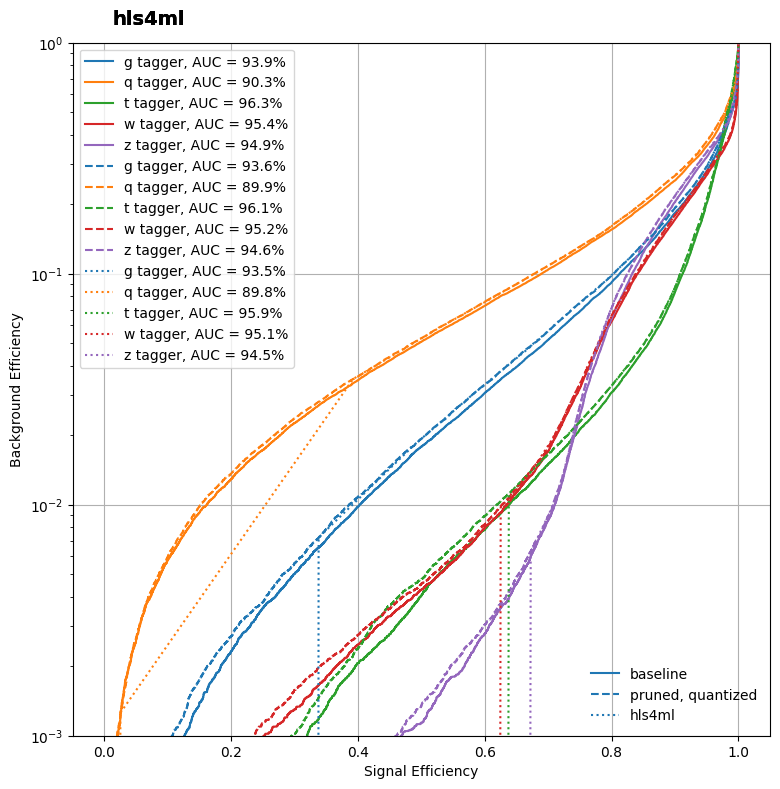

In [9]:
%matplotlib inline
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

model_ref = load_model('model_1/KERAS_check_best_model.h5')
y_ref = model_ref.predict(X_test)

print("Accuracy baseline:  {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
print("Accuracy pruned, quantized: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))
print("Accuracy hls4ml: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_ref, classes)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_qkeras, classes, linestyle='--')
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_hls, classes, linestyle=':')

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--'), Line2D([0], [0], ls=':')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['baseline', 'pruned, quantized', 'hls4ml'], loc='lower right', frameon=False)
ax.add_artist(leg)

## Synthesize
Now let's synthesize this quantized, pruned model.

**The synthesis will take a while**

While the C-Synthesis is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

`tail -f model_3/hls4ml_prj/vivado_hls.log`

In [10]:
hls_model.build(csim=False)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.1 (64-bit)
  **** SW Build 2552052 on Fri May 24 14:47:09 MDT 2019
  **** IP Build 2548770 on Fri May 24 18:01:18 MDT 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /tools/Xilinx/Vivado/2019.1/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/tools/Xilinx/Vivado/2019.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'fang' on host 'fang-virtual-machine' (Linux_x86_64 version 6.5.0-26-generic) on Sat Apr 06 17:09:40 EDT 2024
INFO: [HLS 200-10] On os Ubuntu 22.04.4 LTS
INFO: [HLS 200-10] In directory '/home/fang/PycharmProjects/hls4ml-tutorial/model_3/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/home/fang/PycharmProjects/hls4ml-tutorial/model_3/hls4ml_prj/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject.cpp' to the project
INFO: [HLS 200-10] Adding test bench file 'myproject_test.c

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '4.105',
  'BestLatency': '37',
  'WorstLatency': '37',
  'IntervalMin': '1',
  'IntervalMax': '1',
  'BRAM_18K': '4',
  'DSP': '32',
  'FF': '23779',
  'LUT': '42931',
  'URAM': '0',
  'AvailableBRAM_18K': '270',
  'AvailableDSP': '240',
  'AvailableFF': '126800',
  'AvailableLUT': '63400',
  'AvailableURAM': '0'}}

## Check the reports
Print out the reports generated by Vivado HLS. Pay attention to the Utilization Estimates' section in particular this time.

In [12]:
hls4ml.report.read_vivado_report('model_3/hls4ml_prj')

Found 1 solution(s) in model_3/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Sat Apr  6 17:14:02 2024

* Version:        2019.1 (Build 2552052 on Fri May 24 15:28:33 MDT 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: artix7
* Target device:  xc7a100t-fgg676-2L


== Performance Estimates
+ Timing (ns): 
    * Summary: 
    +--------+-------+----------+------------+
    |  Clock | Target| Estimated| Uncertainty|
    +--------+-------+----------+------------+
    |ap_clk  |   5.00|     4.105|        0.62|
    +--------+-------+----------+------------+

+ Latency (clock cycles): 
    * Summary: 
    +-----+-----+-----+-----+----------+
    |  Latency  |  Interval | Pipeline |
    | min | max | min | max |   Type   |
    +-----+-----+-----+-----+----------+
    |   37|   37|    1|    1| function |
    +-----+-----+-----+-----+----------+

Print the report for the model trained in part 1. Now, compared to the model from part 1, this model has been trained with low-precision quantization, and 75% pruning. You should be able to see that we have saved a lot of resource compared to where we started in part 1. At the same time, referring to the ROC curve above, the model performance is pretty much identical even with this drastic compression!

**Note you need to have trained and synthesized the model from part 1**

In [13]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj')

Found 1 solution(s) in model_1/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Sat Apr  6 12:17:23 2024

* Version:        2019.1 (Build 2552052 on Fri May 24 15:28:33 MDT 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: artix7
* Target device:  xc7a100t-fgg676-2L


== Performance Estimates
+ Timing (ns): 
    * Summary: 
    +--------+-------+----------+------------+
    |  Clock | Target| Estimated| Uncertainty|
    +--------+-------+----------+------------+
    |ap_clk  |   5.00|     4.105|        0.62|
    +--------+-------+----------+------------+

+ Latency (clock cycles): 
    * Summary: 
    +-----+-----+-----+-----+----------+
    |  Latency  |  Interval | Pipeline |
    | min | max | min | max |   Type   |
    +-----+-----+-----+-----+----------+
    |   48|   48|    1|    1| function |
    +-----+-----+-----+-----+----------+

Print the report for the model trained in part 3. Both these models were trained with 75% sparsity, but the new model uses 6-bit precision as well. You can see how Vivado HLS has moved multiplication operations from DSPs into LUTs, reducing the "critical" resource usage.

**Note you need to have trained and synthesized the model from part 3**

In [14]:
hls4ml.report.read_vivado_report('model_2/hls4ml_prj')

Found 1 solution(s) in model_2/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Sat Apr  6 16:40:52 2024

* Version:        2019.1 (Build 2552052 on Fri May 24 15:28:33 MDT 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: artix7
* Target device:  xc7a100t-fgg676-2L


== Performance Estimates
+ Timing (ns): 
    * Summary: 
    +--------+-------+----------+------------+
    |  Clock | Target| Estimated| Uncertainty|
    +--------+-------+----------+------------+
    |ap_clk  |   5.00|     4.105|        0.62|
    +--------+-------+----------+------------+

+ Latency (clock cycles): 
    * Summary: 
    +-----+-----+-----+-----+----------+
    |  Latency  |  Interval | Pipeline |
    | min | max | min | max |   Type   |
    +-----+-----+-----+-----+----------+
    |   43|   43|    1|    1| function |
    +-----+-----+-----+-----+----------+

## NB
Note as well that the Vivado HLS resource estimates tend to _overestimate_ LUTs, while generally estimating the DSPs correctly. Running the subsequent stages of FPGA compilation reveals the more realistic resource usage, You can run the next step, 'logic synthesis' with `hls_model.build(synth=True, vsynth=True)`, but we skipped it in this tutorial in the interest of time.